# Data cleaning process

On this notebook the data cleaning process will be performed over the raw data.

## Importing dependencies

In [1]:
import pandas as pd # To handle data
# To compress the results
import os
import zipfile
from zipfile import ZipFile
# To visualize whole dataframes
pd.set_option("display.max_rows", None, "display.max_columns", None) 

## Loading raw data

We will load the videogames and platforms csv files stored in `raw_data` folder.

In [2]:
platforms_df = pd.read_csv('./raw_data/platforms.zip')
games_df = pd.read_csv('./raw_data/games.zip')

In [3]:
print('Platforms Dataframe')
platforms_df.head()

Platforms Dataframe


,id,platform,version,category,generation,platform_family,region,release_date
0,158,Commodore CDTV,Initial version,computer,NaN,NaN,north_america,1991-03-03
1,158,Commodore CDTV,Initial version,computer,NaN,NaN,europe,1991-11-14
2,158,Commodore CDTV,Initial version,computer,NaN,NaN,australia,1991-07-12
3,339,Sega Pico,Initial version,console,4.0,Sega,NaN,NaN
4,8,PlayStation 2,Initial version,console,6.0,PlayStation,japan,2000-03-04


## Video games dataframe cleaning

### Removing duplicated values

In [4]:
duplicates = games_df.duplicated()
print(f'Number of repeated rows: {duplicates.sum()}')
games_df.drop_duplicates(inplace=True, ignore_index=True)
print(f'Number of remaining rows: {len(games_df)}')

Number of repeated rows: 1254886
Number of remaining rows: 518493


### Column types correction

In [5]:
games_df.dtypes

id                int64
name             object
platform         object
release_date     object
genre            object
category         object
game_modes       object
total_rating    float64
dtype: object

The only column which needs a type correction is `release_date` column.

In [6]:
games_df.release_date = pd.to_datetime(games_df.release_date)
games_df.dtypes

id                       int64
name                    object
platform                object
release_date    datetime64[ns]
genre                   object
category                object
game_modes              object
total_rating           float64
dtype: object

### Missing values handling

In [7]:
print('Number of missing values per column\n')
n_rows = len(games_df)
print(f'Total rows = {len(games_df)}\n')

for c in games_df.columns:
    n_nans = games_df[c].isna().sum()
    print(f'{c} ({games_df[c].dtype}): {n_nans} = {(n_nans/n_rows)*100}%')

Number of missing values per column

Total rows = 518493

id (int64): 0 = 0.0%
name (object): 0 = 0.0%
platform (object): 0 = 0.0%
release_date (datetime64[ns]): 10919 = 2.105910783752143%
genre (object): 12743 = 2.457699525355212%
category (object): 0 = 0.0%
game_modes (object): 48700 = 9.39260510749422%
total_rating (float64): 249179 = 48.05831515565302%


Unfortunately, `total_rating` column has a high percentage of missing values. We have no choice but to remove this rows since this column is the main variable of our analysis and we can not impute it at all. At the same time, for the previous reason, all other columns can preserve their null values since they are secondary variables.

In [8]:
print('Number of missing values per column\n')
n_rows = len(games_df)
print(f'Total rows = {len(games_df)}\n')

games_df = games_df[games_df.total_rating.notna()]

for c in games_df.columns:
    n_nans = games_df[c].isna().sum()
    print(f'{c} ({games_df[c].dtype}): {n_nans} = {(n_nans/n_rows)*100}%')

Number of missing values per column

Total rows = 518493

id (int64): 0 = 0.0%
name (object): 0 = 0.0%
platform (object): 0 = 0.0%
release_date (datetime64[ns]): 70 = 0.01350066442555637%
genre (object): 1504 = 0.2900714185148112%
category (object): 0 = 0.0%
game_modes (object): 6553 = 1.2638550568667273%
total_rating (float64): 0 = 0.0%


We can see that just removing `total_rating` nans the null  values percentage in all the other columns was drastically reduced. This gives us the idea that, if a row had missing `total_rating`, it contained `release_date`, `genre` and `game_modes` null values as well. In other words, rows with no rating were, in general, useless.

We can preserve remaining nans for two reasonts: first, `total_rating` column has the highest importance for our analysis. Remaining nans are distributed across less important columns which could be use useful as auxiliar features in a deeper analysis; and second, if rows whith missing values are removed we will be loosing rated video games.

### Outlier detection

In this phase the **Z-score** of `total_rating` column will be computed to identify outliers. Again, as in the platforms dataframe, the outliers will not be excluded since they could be specially interesting for our purposes.

Number of outlier rows: 384 (0.14258449245119081)%


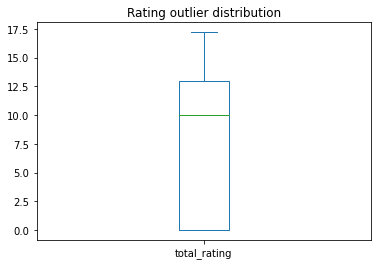

In [9]:
outliers_mask = abs(
    (
        games_df.total_rating-games_df.total_rating.mean()
    )/games_df.total_rating.std()
) >= 4
outliers = games_df[outliers_mask]
print(f'Number of outlier rows: {len(outliers)} ({len(outliers)*100/len(games_df)})%')
_ = outliers.total_rating.plot(kind='box', title='Rating outlier distribution')

As we can see, low ratings are considered as outliers. This rows are very important to our analysis because through them we can get an idea of which videogames had been the worst and which platform are associated with them.

## Platforms dataframe cleaning

### Removing duplicated values

In [10]:
duplicates = platforms_df.duplicated()
print(f'Number of repeated rows: {duplicates.sum()}')
platforms_df.drop_duplicates(inplace=True, ignore_index=True)
print(f'Number of remaining rows: {len(platforms_df)}')

Number of repeated rows: 1
Number of remaining rows: 432


### Column types correction

In [11]:
platforms_df.dtypes

id                   int64
platform            object
version             object
category            object
generation         float64
platform_family     object
region              object
release_date        object
dtype: object

As it can be seen, `generation` column is encoded as `float64` and `release_date` column is shown as `object`. We need to correct this.

In [12]:
platforms_df = platforms_df.astype(
    {'generation':'Int64', 
     'release_date':'datetime64'}
)

print('New dtypes')
platforms_df.dtypes

New dtypes


id                          int64
platform                   object
version                    object
category                   object
generation                  Int64
platform_family            object
region                     object
release_date       datetime64[ns]
dtype: object

### Useless rows deletion

It may happen that some platform does not have any video game registered in the IGDB databases, or platforms related to previously removed rows of `games_df`. Since games are our main interest, then all platforms without associated videogames will be deleted.

In [13]:
print(f'Original number of platforms: {len(platforms_df)}')
platforms_df = platforms_df[platforms_df.platform.isin(games_df.platform)]
print(f'Number of platforms after useless row deletion: {len(platforms_df)}')

Original number of platforms: 432
Number of platforms after useless row deletion: 383


### Missing values handling

In [14]:
print('Number of missing values per column\n')
n_rows = len(platforms_df)
print(f'Total rows = {len(platforms_df)}\n')

for c in platforms_df.columns:
    n_nans = platforms_df[c].isna().sum()
    print(f'{c} ({platforms_df[c].dtype}): {n_nans} = {(n_nans/n_rows)*100}%')

Number of missing values per column

Total rows = 383

id (int64): 0 = 0.0%
platform (object): 0 = 0.0%
version (object): 0 = 0.0%
category (object): 9 = 2.3498694516971277%
generation (Int64): 126 = 32.89817232375979%
platform_family (object): 183 = 47.78067885117493%
region (object): 58 = 15.143603133159269%
release_date (datetime64[ns]): 58 = 15.143603133159269%


As we can see, we have an important ammonunt of missing values in five of eight columns. In this case we can not impute easily because three of the columns with missing values are `object` columns, and in this columns we can not just impute with the most recurrent value because we would be adding a lot of false information. If we want to reduce the number of missing values without loosing data, then we will need to do some research about platform families, release dates, etc, which is not the purpose of this work. The only variable we can impute is `generation` since the generation for a given platform is based on the release date of it.

On the other hand, `category`, `platform_family`, `region` and `release_date` missing values are not so important and we will preserve this columns because two main reasons: first, although they are not so importan to answer the main questions we have, these columns may be importan to perform a deeper analysis; and second, if we just delete the rows with missing values on those columns we will be loosing vital information because all remaining platform this far are linked with one or more video games.

#### Platform generation missing values imputation

Accodring to [this BBC article](https://www.bbc.co.uk/archive/the-8-generations-of-video-game-consoles/zvcjkty), the game consoles generations had been established as follows:

| Generation | Start year | 
| ---------- | ------ |
| 1          | 1972 |    
| 2          | 1976 |
| 3          | 1983 |
| 4          | 1987 |
| 5          | 1993 |
| 6          | 1998 |
| 7          | 2005 |
| 8          | 2012 |
| 9          | 2020 |

Using this information we can impute a lot of `generation` values but we need to be careful. This process can not be performed directly, since the generation for a given console is stablished according to the release date of its **initial version**. For example, *Super Nintendo Entertainment System (SNES)* is a 4th generation console, but its last version was released on 2017, four generations later!. 

The algorithm is the following:

* For a row where `version` == 'Initial version' and `generation` == Nan and `release_date` != NaN:
    * impute the generation according to the year of its release date, lets say `generation` = **G**
    * for all other rows where `platform` == **current platform**:
        * impute generation with **G**

As we need to find a lot of generations, the following function was built.

In [15]:
def getGeneration(release_year):
    """
        This function finds a video game console generation
        
        Params
        ------
        release_year <int>: Release year
        
        Returns
        -------
        generation <int>: Video games generation of the given release year
    """
    if release_year < 1972:
        generation = 0
    if release_year >= 1972 and release_year < 1976:
        generation = 1
    if release_year >= 1976 and release_year < 1983:
        generation = 2
    if release_year >= 1983 and release_year < 1987:
        generation = 3
    if release_year >= 1987 and release_year < 1993:
        generation = 4
    if release_year >= 1993 and release_year < 1998:
        generation = 5
    if release_year >= 1998 and release_year < 2005:
        generation = 6
    if release_year >= 2005 and release_year < 2012:
        generation = 7
    if release_year >= 2012 and release_year < 2020:
        generation = 8
    if release_year >= 2020:
        generation = 9
    
    return generation

In [16]:
print(f"Number of NaN's in generation column before imputation {platforms_df.generation.isnull().sum()}")

for i in range(len(platforms_df)):
    # Getting current row
    row = platforms_df.iloc[i]
    # Checking if version is Initial version and generation == NaN and 
    # release_date != NaN
    if (row[2]=='Initial version' and pd.isnull(row[4])
        and not pd.isnull(row[7])):
        # Getting generation according the release year
        release_year = row[7].year
        current_platform = row[1]
        platforms_df.loc[
            platforms_df.platform == current_platform, "generation"
        ] = getGeneration(release_year)

print(f"Number of NaN's in generation column after imputation {platforms_df.generation.isnull().sum()}")
        

Number of NaN's in generation column before imputation 126
Number of NaN's in generation column after imputation 89


We can see that there are a lot of remaning NaN's in `generation` column. Now a different algorithm will be used to get an approximation:

* For a row where `generation` is null:
    * get all rows where `platform` == current platform
    * compare all the release years and get the minimum
    * impute the generation according to the first recorded release year

In [17]:
print(f"Number of NaN's in generation column before imputation {platforms_df.generation.isnull().sum()}")

for i in range(len(platforms_df)):
    # Getting current row
    row = platforms_df.iloc[i]
    # Checking if generation column value is null
    if pd.isnull(row[4]):
        # Getting current platform
        current_platform = row[1]
        # Getring all rows corresponding to the current platform
        platform_records=platforms_df[platforms_df.platform==current_platform]
        # Getting the first release year recorded for the current platform
        first_release_year = platform_records.release_date.dt.year.min()
        # If the first release year is not null, then impute the generation in
        # all the rows corresponding to the current platform
        if not pd.isnull(first_release_year):
            platforms_df.loc[
                platforms_df.platform == current_platform, "generation"
            ] = getGeneration(first_release_year)
            
print(f"Number of NaN's in generation column after imputation {platforms_df.generation.isnull().sum()}")

Number of NaN's in generation column before imputation 89
Number of NaN's in generation column after imputation 38


With the latter imputation algorithm the generation column missing values were reduced significantly. There is nothing more we can do to impute generations programmatically because all remaining rows with missing generation also have missing release date.

In [18]:
platforms_df.head(10)

,id,platform,version,category,generation,platform_family,region,release_date
0,158,Commodore CDTV,Initial version,computer,4,NaN,north_america,1991-03-03
1,158,Commodore CDTV,Initial version,computer,4,NaN,europe,1991-11-14
2,158,Commodore CDTV,Initial version,computer,4,NaN,australia,1991-07-12
4,8,PlayStation 2,Initial version,console,6,PlayStation,japan,2000-03-04
5,8,PlayStation 2,Initial version,console,6,PlayStation,north_america,2000-10-26
6,8,PlayStation 2,Initial version,console,6,PlayStation,europe,2000-11-24
7,8,PlayStation 2,Initial version,console,6,PlayStation,australia,2000-11-30
8,8,PlayStation 2,Initial version,console,6,PlayStation,china,2003-12-20
9,8,PlayStation 2,Slimline,console,6,PlayStation,north_america,2004-10-29
10,39,iOS,Initial version,operating system,7,NaN,worldwide,2007-06-29


The remaining columns will remain as they are because the data with missing values is still useful since we can link and join this information with video games data.

### Outlier detection

In this case outliers will not be a problem, in fact, detecting outliers can guide us to analyze specific subsets of data to unravel very hidden insights.

For example, an interesting question would be: How many versions a platform has?

<AxesSubplot:ylabel='Frequency'>

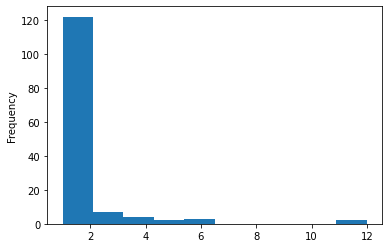

In [19]:
platforms_df.groupby(
    ['platform', 
     'version'
    ]).size().groupby('platform').size().sort_values().plot(kind='hist')

From the above distribution we can see there are some platforms with more than 4 versions, does this platforms have good or bad videogames?, does the number of versions influences games quality? 

Now, we can save this cleaned dataframes

In [20]:
# Creating the data folder if it does not exists
if not os.path.exists('./cleaned_data'):
    os.makedirs('./cleaned_data')

# Storing the csvs
platforms_df.to_csv('./cleaned_data/platforms.csv', index=False)
games_df.to_csv('./cleaned_data/games.csv', index=False)

# Compressing the csvs
with ZipFile('./cleaned_data/platforms.zip', 'w') as zip:
    zip.write('./cleaned_data/platforms.csv', 
              compress_type=zipfile.ZIP_DEFLATED, 
              compresslevel=9)

with ZipFile('./cleaned_data/games.zip', 'w') as zip:
    zip.write('./cleaned_data/games.csv', 
              compress_type=zipfile.ZIP_DEFLATED, 
              compresslevel=9)
    
# Removing the csvs
os.remove('./cleaned_data/platforms.csv')
os.remove('./cleaned_data/games.csv')